In [1]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import cifar_nets
import training

NUM_CLASSES = 10

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = False
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

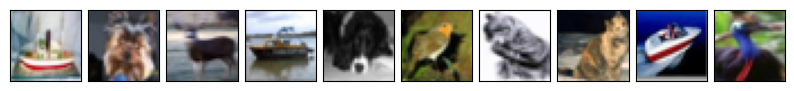

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1)

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=7, shuffle=True))

img_shape = train_dataset[0][0].shape



In [8]:
# model_dp

# m = torchvision.models.resnet50()
# m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# m.fc = nn.Linear(m.fc.in_features, args.latent_dim)
# encoder = m



In [9]:
# # Unfreeze only conv1 + layer1 + fc
# for name, param in m.named_parameters():
#     if "conv1" in name or "layer1" in name or "fc" in name:
#         param.requires_grad = True  # Allow training
#     else:
#         param.requires_grad = False  # Keep frozen


In [ ]:
#Model
encoder = cifar_nets.Reg_Encoder(img_shape[0], args.latent_dim)
classifier = cifar_nets.Reg_Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_ete_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [11]:
classifier

Classifier(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=2048, out_features=128, bias=True)
    )
  )
  (classifier_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=10, bias=

--- EPOCH 1/200 ---
test_batch (Avg. Loss 1.131, Accuracy 59.4): 100%|██████████| 313/313 [00:05<00:00, 56.74it/s]
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 1
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 2
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 3
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 4
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 5
--- EPOCH 6/200 ---
test_batch (Avg. Loss 1.029, Accuracy 70.0): 100%|██████████| 313/313 [00:05<00:00, 56.86it/s]
--- EPOCH 11/200 ---
test_batch (Avg. Loss 1.522, Accuracy 68.6): 100%|██████████| 313/313 [00:05<00:00, 56.16it/s]
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 14
--- EPOCH 16/200 ---
test_batch (Avg. Loss 1.742, Accuracy 69.7): 100%|██████████| 313/313 [00:06<00:00, 50.90it/s]
--- EPOCH 21/200 ---
test_batch (Avg. Loss 1.951, Accuracy 69.0): 100%|██████████| 313/313 [00:05<00:00, 53.07it/s]


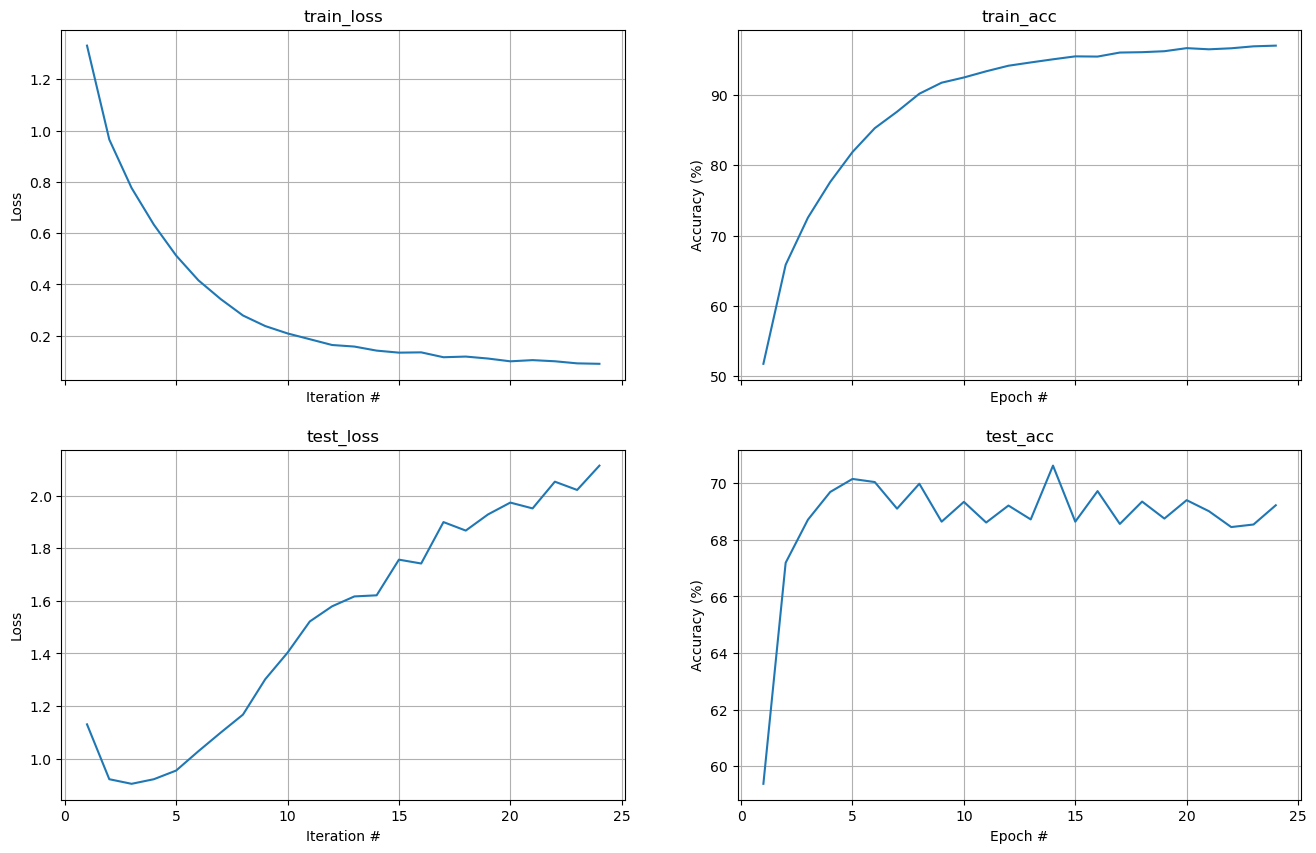

In [12]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=200, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)